In [12]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
from einops import rearrange
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Annotations file exploration

In [2]:
CSV_NAME = 'EPIC_100_train.csv'

In [3]:
df = pd.read_csv(CSV_NAME)
df.head(1)

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]


In [4]:
df['verb_class'].unique()

array([ 3,  6,  0,  5,  1,  4, 10,  7, 59, 77, 13, 23,  9, 38, 17, 28, 12,
        2, 72, 16, 35, 60,  8, 37, 18, 14, 11, 20, 39, 31, 15, 41, 22, 45,
       24, 42, 19, 34, 51, 27, 53, 52, 48, 47, 87, 64, 71, 49, 32, 21, 33,
       56, 44, 73, 25, 63, 30, 36, 82, 67, 26, 50, 89, 46, 61, 70, 76, 68,
       74, 40, 55, 86, 43, 91, 57, 66, 83, 94, 81, 29, 65, 58, 78, 62, 95,
       54, 85, 88, 69, 75, 79, 84, 80, 92, 96, 90, 93], dtype=int64)

In [5]:
columns = ['participant_id', 'video_id', 'start_frame', 'stop_frame', 'verb_class']
clip_df = df[columns]
clip_df.head()

,participant_id,video_id,start_frame,stop_frame,verb_class
0,P01,P01_01,8,202,3
1,P01,P01_01,262,370,6
2,P01,P01_01,1498,1572,3
3,P01,P01_01,28785,28852,0
4,P01,P01_01,28888,28932,3


In [7]:
clip_df['num_frames'] = clip_df.apply(lambda row: row.stop_frame - row.start_frame, axis = 1)

C:\Users\34609\AppData\Local\Temp\ipykernel_15320\265523361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clip_df['num_frames'] = clip_df.apply(lambda row: row.stop_frame - row.start_frame, axis = 1)


In [8]:
clip_df.head()

,participant_id,video_id,start_frame,stop_frame,verb_class,num_frames
0,P01,P01_01,8,202,3,194
1,P01,P01_01,262,370,6,108
2,P01,P01_01,1498,1572,3,74
3,P01,P01_01,28785,28852,0,67
4,P01,P01_01,28888,28932,3,44


In [18]:
a = clip_df['num_frames']

<Axes: ylabel='Frequency'>

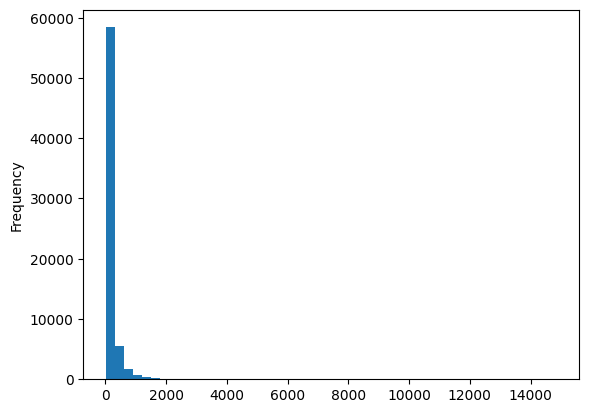

In [22]:
a.plot(kind='hist', bins=50)

In [23]:
a_arr = np.array(a)
a_arr

array([194, 108,  74, ..., 461, 181, 390], dtype=int64)

(array([15285., 22597.,  9644.,  5283.,  3147.,  2187.,  1607.,  1311.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <BarContainer object of 8 artists>)

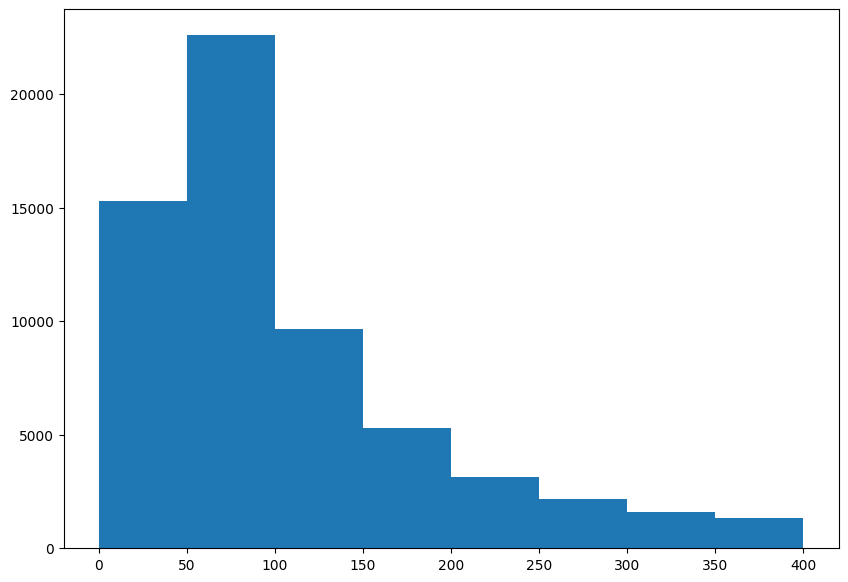

In [24]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a_arr, bins = [0, 50, 100, 150, 200, 250, 300, 350, 400])

In [26]:
b = [x for x in a_arr if x > 200]
print(f'Total of clips with more than 200 frames: {len(b)}')
print(f'% of frames with more than 200 frames: {(len(b)/len(a)) * 100}')

Total of clips with more than 200 frames: 14329
% of frames with more than 200 frames: 21.317523840695063


In [13]:
df_drop = clip_df.drop(clip_df[clip_df['video_id']== 'P23_04'].index)

In [14]:
df_drop['video_id'].unique()

array(['P01_01', 'P01_02', 'P01_03', 'P01_04', 'P01_05', 'P01_06',
       'P01_07', 'P01_08', 'P01_09', 'P01_102', 'P01_103', 'P01_104',
       'P01_105', 'P01_106', 'P01_107', 'P01_108', 'P01_109', 'P01_10',
       'P01_16', 'P01_17', 'P01_18', 'P01_19', 'P02_01', 'P02_02',
       'P02_03', 'P02_04', 'P02_05', 'P02_06', 'P02_07', 'P02_08',
       'P02_09', 'P02_101', 'P02_102', 'P02_103', 'P02_104', 'P02_105',
       'P02_107', 'P02_108', 'P02_109', 'P02_10', 'P02_110', 'P02_111',
       'P02_112', 'P02_113', 'P02_114', 'P02_115', 'P02_116', 'P02_118',
       'P02_119', 'P02_11', 'P02_120', 'P02_121', 'P02_122', 'P02_123',
       'P02_124', 'P02_126', 'P02_127', 'P02_128', 'P02_129', 'P02_130',
       'P02_131', 'P02_132', 'P02_133', 'P02_134', 'P02_135', 'P03_02',
       'P03_03', 'P03_04', 'P03_05', 'P03_06', 'P03_07', 'P03_08',
       'P03_09', 'P03_101', 'P03_102', 'P03_106', 'P03_107', 'P03_108',
       'P03_109', 'P03_10', 'P03_110', 'P03_111', 'P03_112', 'P03_113',
       'P03_

In [6]:
clip_info = clip_df.iloc[0]
clip_info

participant_id       P01
video_id          P01_01
start_frame            8
stop_frame           202
verb_class             3
Name: 0, dtype: object

In [42]:
clip_df['participant_id'].unique()

array(['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09',
       'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P19',
       'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28',
       'P29', 'P30', 'P31', 'P35', 'P37'], dtype=object)

In [40]:
error = clip_df[clip_df['video_id'] == 'P23_04']

In [41]:
print(error)

      participant_id video_id  start_frame  stop_frame  verb_class
46123            P23   P23_04            1         580           0
46124            P23   P23_04          586        1816          12
46125            P23   P23_04        15381       15867          12
46126            P23   P23_04        82392       82725           2
46127            P23   P23_04        82764       83062          12
...              ...      ...          ...         ...         ...
46306            P23   P23_04        79679       79736           0
46307            P23   P23_04        79736       79788           5
46308            P23   P23_04        79914       79983           0
46309            P23   P23_04        80019       80485           2
46310            P23   P23_04        80922       81630           2

[188 rows x 5 columns]


In [16]:
df_drop.shape

(67029, 5)

### Dataset class testing

In [7]:
middel_frame = clip_info['start_frame'] + (clip_info['stop_frame'] - clip_info['start_frame']) // 2
clip_frames = (middel_frame - 30 // 2, middel_frame + 30 // 2)
clip_paths = ['home/' + 'frame_' + str(x).rjust(10, '0') + '.jpg' for x in range(clip_frames[0], clip_frames[1])]

In [8]:
for path in clip_paths:
    print(path)
    break

home/frame_0000000090.jpg


In [103]:
x = torch.rand((1920, 1080, 3)).unsqueeze(-1)
y = torch.rand((1920, 1080, 3)).unsqueeze(-1)
z = torch.rand((1920, 1080, 3)).unsqueeze(-1)

print(x.shape)

torch.Size([1920, 1080, 3, 1])


In [104]:
lst = [x, y, z]
v = torch.cat(lst, -1)
print(v.shape)

torch.Size([1920, 1080, 3, 3])


In [107]:
x = torch.rand((640, 640, 3))
x
resize = T.Resize(size=(224,224))
x_resized = resize(x)
print(x_resized.shape)

torch.Size([640, 224, 224])


In [75]:
missing_frames = 7

# check if missing frames is odd in order to ensure that after padding, 
# num_frames equals NUM_FRAMES
if missing_frames % 2 == 0:
    print('1')
    pad = (missing_frames // 2, missing_frames // 2)
else:
    print('2')
    pad = (missing_frames // 2 + 1, missing_frames // 2)
print(f'pad: {pad}')
video = F.pad(v, pad, 'constant', 0)
print(video.shape)

2
pad: (4, 3)
torch.Size([3, 1920, 1080, 10])


In [89]:
# pool of size=3, stride=2
v1 = rearrange(video, 'c w h t -> c (w h) t')
print(f'v1 shape: {v1.shape}')
total = 10
num = 3
s = (total - 1)//(num - 1)
print(f'stride: {s}')
m = torch.nn.MaxPool1d(kernel_size = 2, stride=s)
output = m(v1)
output = rearrange(output, 'c (w h) t -> c w h t', h = 1080)
print(output.shape)

v1 shape: torch.Size([3, 2073600, 10])
stride: 4
torch.Size([3, 1920, 1080, 3])


In [86]:
a = 1920 * 1080
a

2073600

### image load test

In [14]:
img_path = 'sample_image.jpg'
resize = T.Resize(size=(160, 160))

In [11]:
x = Image.open(img_path)

In [17]:
x.mode

'RGB'

In [12]:
y = torch.tensor(np.asarray(x)).to('cpu')
print(y.shape)

torch.Size([200, 150, 3])


In [13]:
y = rearrange(y, 'h w c -> c h w')
print(y.shape)

torch.Size([3, 200, 150])


In [15]:
y = resize(y).unsqueeze(-1)
print(y.shape)

torch.Size([3, 160, 160, 1])


In [30]:
lst = [y, y, y, y, y, y, y, y, y, y]
v = torch.cat(lst, -1)
print(z.shape)

torch.Size([3, 25600, 10])


In [21]:
num = 5
total = 10

In [22]:
s = (total - 1)//(num - 1)
print(f'stride: {s}')
pool = torch.nn.MaxPool1d(kernel_size = 2, stride=s)

stride: 2


In [34]:
v1 = rearrange(v, 'c w h t -> c (w h) t')
print(v1.type())
v1 = pool(v1.float())
v1 = rearrange(v1, 'c (w h) t2 -> c w h t2', h=160)
print(v.shape)

torch.ByteTensor
torch.Size([3, 160, 160, 10])


In [2]:
count = 0
for x in range(3, 10):
    print(x)
    count += 1
count

3
4
5
6
7
8
9


7

In [27]:
a = torch.rand((3, 112, 112, 256))

In [32]:
range_f = 257 - 200
rand_f = torch.randint(low=1, high=range_f, size=(1,))
print(rand_f)
clip = rearrange(a, 'c w h t1 -> t1 c w h')
clip = clip[rand_f:rand_f+200]
clip = rearrange(clip, 't2 c w h -> c w h t2')  
print(clip.size())

tensor([31])
torch.Size([3, 112, 112, 200])


In [35]:
scaler = torch.cuda.amp.GradScaler()

C:\Users\34609\anaconda3\envs\transformer_venv\lib\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
